In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib
import json
import os

# load and explore data: discover and handling missing data and outliers

In [5]:
#https://www.kaggle.com/datasets/kaggle/titanic
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load data
def load_data(path):
    return pd.read_csv(path)
    

df = load_data('/kaggle/input/playground-series-s5e8/train.csv')
df.shape

../input/playground-series-s5e8/sample_submission.csv
../input/playground-series-s5e8/train.csv
../input/playground-series-s5e8/test.csv


(750000, 18)

In [6]:
df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [8]:
df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [9]:
#check importance of features
for col in df.columns:
    print(df[col].value_counts())

id
0         1
499993    1
499995    1
499996    1
499997    1
         ..
250001    1
250002    1
250003    1
250004    1
749999    1
Name: count, Length: 750000, dtype: int64
age
32    37235
33    34511
31    34301
34    34131
35    33057
      ...  
90        6
92        5
94        4
95        3
91        1
Name: count, Length: 78, dtype: int64
job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64
marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64
education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64
default
no     737151
yes     12849
Name: count, dtype: int64
balance
 0        93159
 5         4174
 4         3741
-1    

In [10]:
#check missing values replaced by "unknown"
df_missing = df.replace("unknown", np.nan)

In [11]:
missing_percent = df_missing.isna().sum() / len(df_missing) * 100
missing_data = pd.DataFrame({"missinf value count": df_missing.isna().sum(), "missing percent": missing_percent})
missing_data.sort_values(by="missing percent", ascending=False)

,missinf value count,missing percent
poutcome,672450,89.660000
contact,231627,30.883600
education,21299,2.839867
job,2917,0.388933
day,0,0.000000
previous,0,0.000000
pdays,0,0.000000
campaign,0,0.000000
duration,0,0.000000
month,0,0.000000


In [12]:
df.groupby("poutcome")['y'].mean()

poutcome
failure    0.132794
other      0.166848
success    0.764004
unknown    0.101898
Name: y, dtype: float64

In [13]:
#add missing_col feature for most missed data
for col in ["poutcome", "contact"]:
    df[f"missing_{col}"] = df[col] == "unknown"

In [14]:
df.groupby("education")['y'].mean()

education
primary      0.083097
secondary    0.105491
tertiary     0.162649
unknown      0.133387
Name: y, dtype: float64

In [15]:
df.groupby("job")['y'].mean()

job
admin.           0.116453
blue-collar      0.067438
entrepreneur     0.081386
housemaid        0.084653
management       0.150392
retired          0.246241
self-employed    0.129443
services         0.082714
student          0.340784
technician       0.118321
unemployed       0.179823
unknown          0.120672
Name: y, dtype: float64

In [16]:
df = df.drop("id", axis=1)

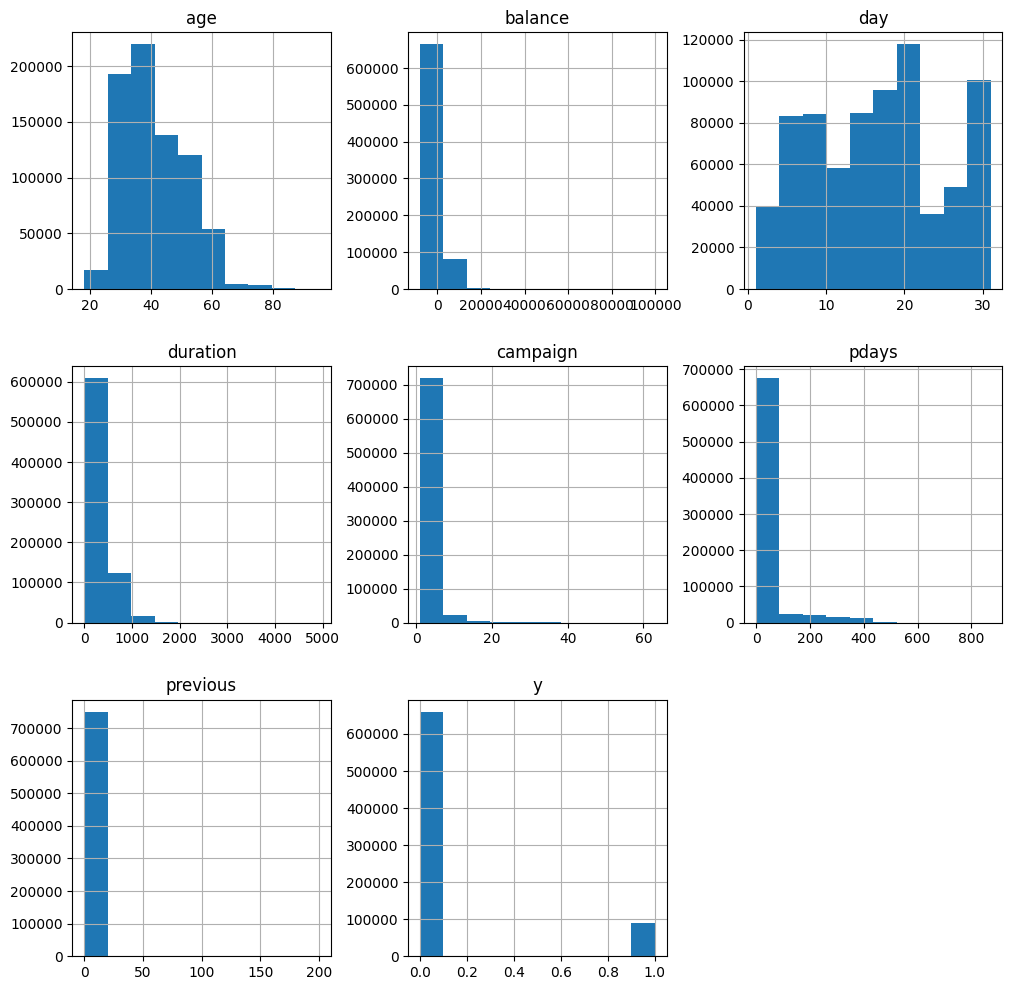

In [17]:
#visulation of data
df.select_dtypes(include=["int64", "float64"]).hist(figsize=(12, 12))
plt.grid(True)
plt.show()

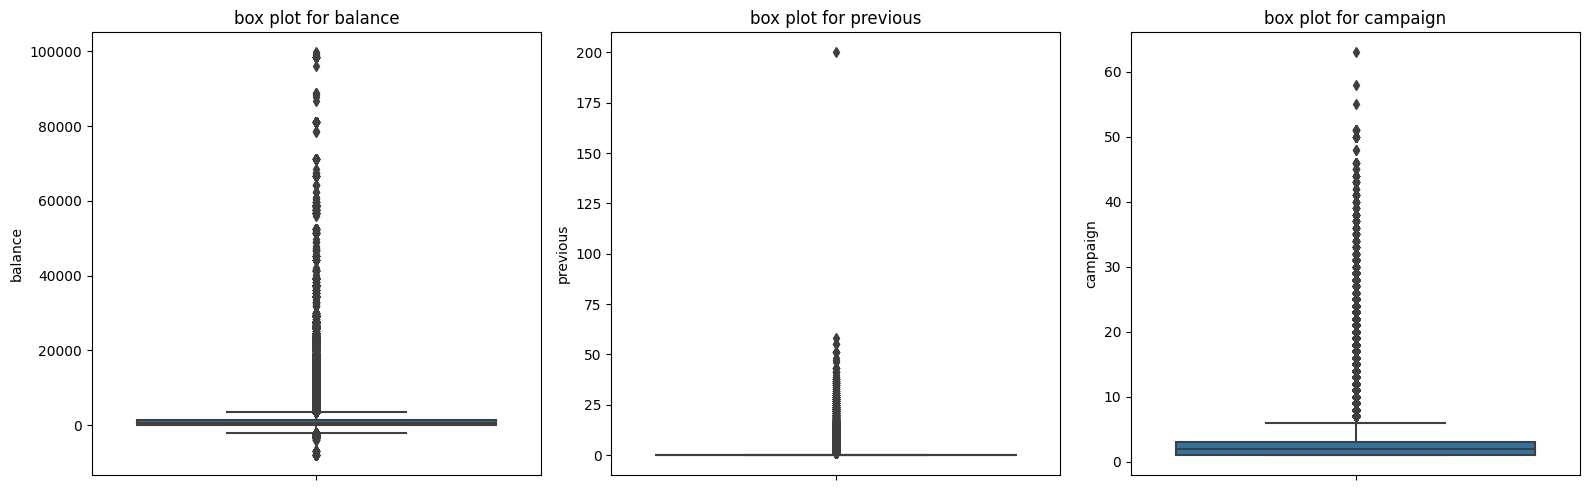

In [18]:
#box plot for most skewed data
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.boxplot(y="balance", data=df)
plt.title("box plot for balance")
plt.xticks(rotation=45)


plt.subplot(1,3,2)
sns.boxplot(y="previous", data=df)
plt.title("box plot for previous")
plt.xticks(rotation=45)


plt.subplot(1,3,3)
sns.boxplot(y="campaign", data=df)
plt.title("box plot for campaign")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [19]:
correlation_matrix = df.select_dtypes(include=["int64", "float64"]).corr()
print(correlation_matrix["y"].sort_values(ascending=False))

y           1.000000
duration    0.519283
balance     0.122513
previous    0.119552
pdays       0.089277
age         0.009523
day        -0.049625
campaign   -0.075829
Name: y, dtype: float64


In [20]:
df.select_dtypes(include=["int64", "float64"]).skew()

age          0.586137
balance     12.304123
day          0.054014
duration     2.048776
campaign     4.810437
pdays        3.625049
previous    13.749885
y            2.329296
dtype: float64

In [21]:
#handling big outliers using capping
def winsorize(X, change_list,lower=0.01, upper=0.99):
    X_df = X.copy()

    for col in change_list:
        if pd.api.types.is_numeric_dtype(X_df[col]):
            lower_bound = X_df[col].quantile(lower)
            upper_bound = X_df[col].quantile(upper)
            X_df[col] = np.clip(X_df[col], lower_bound, upper_bound)
        else:
            print(f"Skipping non-numeric column: '{col}'")

    return X_df

In [22]:
df_cleane = winsorize(df, ["balance", "previous", "campaign"])

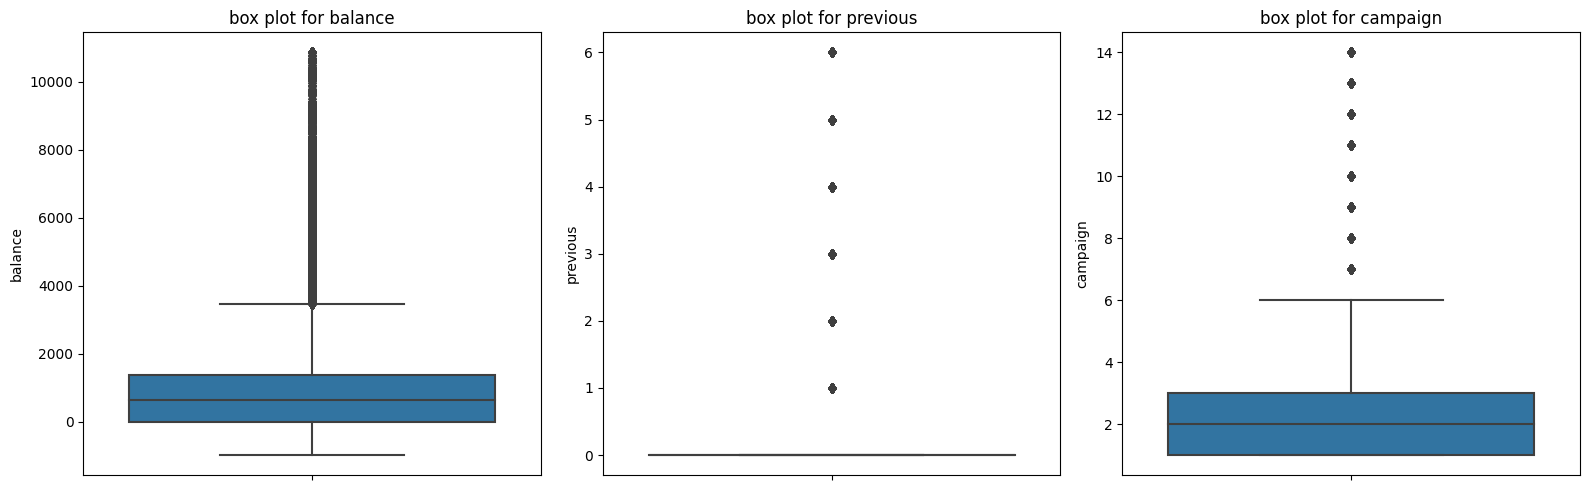

In [23]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.boxplot(y="balance", data=df_cleane)
plt.title("box plot for balance")
plt.xticks(rotation=45)


plt.subplot(1,3,2)
sns.boxplot(y="previous", data=df_cleane)
plt.title("box plot for previous")
plt.xticks(rotation=45)


plt.subplot(1,3,3)
sns.boxplot(y="campaign", data=df_cleane)
plt.title("box plot for campaign")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# spliting dataset

In [25]:
#https://www.kaggle.com/datasets/kaggle/titanic
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load data
def load_data(path):
    return pd.read_csv(path)
    

df = load_data('/kaggle/input/playground-series-s5e8/train.csv')

#using train_test_split to plit randomly to train and test set
train_set, test_set =train_test_split(df, test_size=0.2, random_state=42)

../input/playground-series-s5e8/sample_submission.csv
../input/playground-series-s5e8/train.csv
../input/playground-series-s5e8/test.csv


In [26]:
x_train = train_set.drop("y", axis=1)
y_train = train_set["y"]

x_test = test_set.drop("y", axis=1)
y_test = test_set["y"]

In [27]:
x_train.shape

(600000, 17)

In [28]:
x_test.shape

(150000, 17)

In [29]:
df["y"].sum()/len(df)

0.12065066666666667

In [30]:
y_train.sum()/len(y_train)

0.12047166666666667

In [31]:
y_test.sum()/len(y_test)

0.12136666666666666

# preprocess and train linear models

In [32]:
class AddDropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop, missing_features, addfearures=True):
        self.features_to_drop = features_to_drop if features_to_drop is not None else []
        self.missing_features = missing_features if missing_features is not None else []
        self.addfearures = addfearures
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_transformed = X.copy()

        #add missing_col for features with most missing values
        if self.addfearures:
            for col in self.missing_features:
                if col in X.columns:
                    if isinstance(col, object):
                        X[f"missing_{col}"] = X[col]=="unknown"
                    elif isinstance(col, number):
                        X[f"missing_{col}"] = X[col]==-1

        #drop not needed feature
        for feature in self.features_to_drop:
            if feature in X_transformed.columns:
                X_transformed.drop(feature, axis=1, inplace=True)

        return X_transformed

In [33]:
#stage1 pipeline: features engeniring
drop_columns = ["id"]
missing_list = ["poutcome", "contact"]
stage1_pipeline= Pipeline([
    ('change', AddDropFeatures(drop_columns, missing_list)),
])
x_stage1 = stage1_pipeline.fit_transform(x_train)
print(f"Stage 1 columns: {list(x_stage1.columns)}")

Stage 1 columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [34]:
def cap_outliers(X, lower=0.01, upper=0.99):
    X = np.asarray(X)
    X_capped = np.copy(X)

    lower_bounds = np.percentile(X, lower * 100, axis=0)
    upper_bounds = np.percentile(X, upper * 100, axis=0)

    for i in range(X.shape[1]):
        X_capped[:, i] = np.clip(X[:, i], lower_bounds[i], upper_bounds[i])
    return X_capped

capping = FunctionTransformer(cap_outliers, validate=False)

#no impute since there is no missing values
num_Pipeline = Pipeline([
    ('capping', capping),
    ('scaler', StandardScaler())
])

#capping and transform columns with high skew
#consider log transform since there is no left skewed feature
log_Pipeline = Pipeline([
    ('capping', capping),
    ('log', FunctionTransformer(lambda x: np.log1p(np.clip(x, 0, None)), feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

cat_Pipeline = Pipeline([
    ('encode', OneHotEncoder(handle_unknown="ignore"))
])

cat_attribs = x_stage1.select_dtypes(include="object").columns.tolist()
nums = x_stage1.select_dtypes(exclude="object").columns.tolist()

skew_threshold = 1
skewness = x_stage1.select_dtypes(include=['number']).skew()
skewed_attrib = skewness[abs(skewness) > skew_threshold].index.tolist()

num_attribs = [num for num in nums if num not in skewed_attrib]
preprocess_transform = ColumnTransformer(
    transformers = [
    ('num', num_Pipeline, num_attribs),
    ('cat', cat_Pipeline, cat_attribs),
    ('skewed', log_Pipeline, skewed_attrib)
    ],
    remainder='passthrough')

x_train_prepared = preprocess_transform.fit_transform(x_stage1)

In [37]:
#use cross validation to compare between models
#metrics are f1 score, recall, precision, auc score
#accurracy less considering since classes are imbalanced
def cross_validation_score(model, data):
    scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
    cv_results = cross_validate(model, data, y_train, cv=3, scoring=scoring)


    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric.capitalize():10}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

In [38]:
#this create because after tran precision > recall, and low f1 score in all models
#goal is to make more balance between recision and recall
#note: this function is not create by me
def cv_best_threshold(model, X, y, cv=5):
    # Get out-of-fold predicted probabilities
    y_scores = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]

    # Precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


    best_idx = np.argmax(f1_scores)

    return {
        "threshold": thresholds[best_idx],
        "precision": precisions[best_idx],
        "recall": recalls[best_idx],
        "f1": f1_scores[best_idx]
    }


In [39]:
#lositic regression and evaluate it
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train_prepared, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
cross_validation_score(log_reg, x_train_prepared)

Accuracy  : 0.9164 (+/- 0.0013)
F1        : 0.6010 (+/- 0.0067)
Precision : 0.7070 (+/- 0.0078)
Recall    : 0.5226 (+/- 0.0070)
Roc_auc   : 0.9438 (+/- 0.0010)


In [41]:
#stochastic gradient descent classification and validate it
sgd_cls = SGDClassifier(random_state=42)
sgd_cls.fit(x_train_prepared, y_train)

SGDClassifier(random_state=42)

In [42]:
cross_validation_score(sgd_cls, x_train_prepared)

Accuracy  : 0.9148 (+/- 0.0021)
F1        : 0.5799 (+/- 0.0536)
Precision : 0.7157 (+/- 0.0451)
Recall    : 0.4907 (+/- 0.0955)
Roc_auc   : 0.9424 (+/- 0.0020)


# preprocess and train tree based lodels
decision tree, random forest, xgboost

In [43]:
#pipeline for tree based model: no scale, no transform
cat_Pipeline = Pipeline([
    ('encode', OneHotEncoder(handle_unknown="ignore"))
])

cat_attribs = x_stage1.select_dtypes(include="object").columns.tolist()

preprocess_transform_tree = ColumnTransformer(
    transformers = [
        ('cat', cat_Pipeline, cat_attribs),
    ],
    remainder='passthrough')

x_train_prepared_tree = preprocess_transform_tree.fit_transform(x_stage1)

In [44]:
clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)
clf.fit(x_train_prepared_tree, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=4,
                       random_state=42)

In [45]:
cross_validation_score(clf, x_train_prepared_tree)

Accuracy  : 0.9091 (+/- 0.0012)
F1        : 0.5113 (+/- 0.0087)
Precision : 0.7257 (+/- 0.0070)
Recall    : 0.3947 (+/- 0.0086)
Roc_auc   : 0.8862 (+/- 0.0014)


In [46]:
forest_cls = RandomForestClassifier(random_state=42)
forest_cls.fit(x_train_prepared_tree, y_train)

RandomForestClassifier(random_state=42)

In [47]:
cross_validation_score(forest_cls, x_train_prepared_tree)

Accuracy  : 0.9313 (+/- 0.0013)
F1        : 0.6911 (+/- 0.0068)
Precision : 0.7535 (+/- 0.0054)
Recall    : 0.6382 (+/- 0.0091)
Roc_auc   : 0.9601 (+/- 0.0014)


In [48]:
xgb_clf = XGBClassifier(
    tree_method="hist",
    random_state=42
)

xgb_clf.fit(x_train_prepared_tree, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [49]:
cross_validation_score(xgb_clf, x_train_prepared_tree)

Accuracy  : 0.9343 (+/- 0.0014)
F1        : 0.7088 (+/- 0.0076)
Precision : 0.7599 (+/- 0.0041)
Recall    : 0.6641 (+/- 0.0104)
Roc_auc   : 0.9658 (+/- 0.0009)


# fine tune best mode

In [50]:
#fine tune xgboost since it has the best scores
param_dist = {
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.5, 1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [200, 500, 800]
}

random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search.fit(x_train_prepared_tree, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [200, 500, 800],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42)

In [53]:
best_model = random_search.best_estimator_
cross_validation_score(best_model, x_train_prepared_tree)

Accuracy  : 0.9361 (+/- 0.0013)
F1        : 0.7187 (+/- 0.0065)
Precision : 0.7655 (+/- 0.0061)
Recall    : 0.6773 (+/- 0.0086)
Roc_auc   : 0.9678 (+/- 0.0008)


In [54]:
#choose best threshold for fine tuned xgboost
result = cv_best_threshold(best_model, x_train_prepared_tree, y_train)

In [55]:
result

{'threshold': 0.3699197,
 'precision': 0.7057717616093251,
 'recall': 0.7790213466513565,
 'f1': 0.7405897361706605}

# evaluate in test set

In [56]:
#choose fine tuned xgboost classifier as final model
choosen_model = Pipeline([
    ('stage1', stage1_pipeline),
    ('final_pipleine', preprocess_transform_tree),
    ('model', best_model)
])

In [57]:
#evalute on test set(without choosen threshold)
y_pred = choosen_model.predict(x_test)
y_true = y_test 

print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1       :", f1_score(y_true, y_pred))

Accuracy : 0.9369133333333334
Precision: 0.7709857408555487
Recall   : 0.6831090359791266
F1       : 0.7243920198048639


In [58]:
#evalute on test set(withchoosen threshold)
y_scores = choosen_model.predict_proba(x_test)[:, 1] 
y_predict_change = (y_scores > result["threshold"])

In [59]:
print("Accuracy :", accuracy_score(y_true, y_predict_change ))
print("Precision:", precision_score(y_true, y_predict_change ))
print("Recall   :", recall_score(y_true, y_predict_change ))
print("F1       :", f1_score(y_true, y_predict_change ))

Accuracy : 0.9341733333333333
Precision: 0.7078904027549034
Recall   : 0.7791266135677012
F1       : 0.7418022069975421


In [61]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

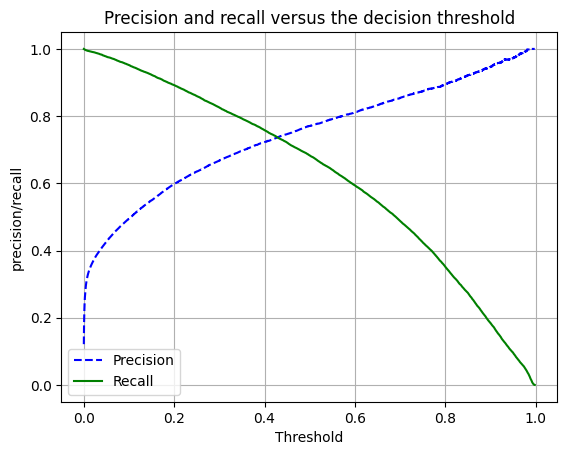

In [62]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
 plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
 plt.title("Precision and recall versus the decision threshold")
 plt.xlabel("Threshold")
 plt.ylabel("precision/recall")
 plt.legend()
 plt.grid(True)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [63]:
roc_auc = roc_auc_score(y_true, y_scores)
roc_auc

0.9680792710300474

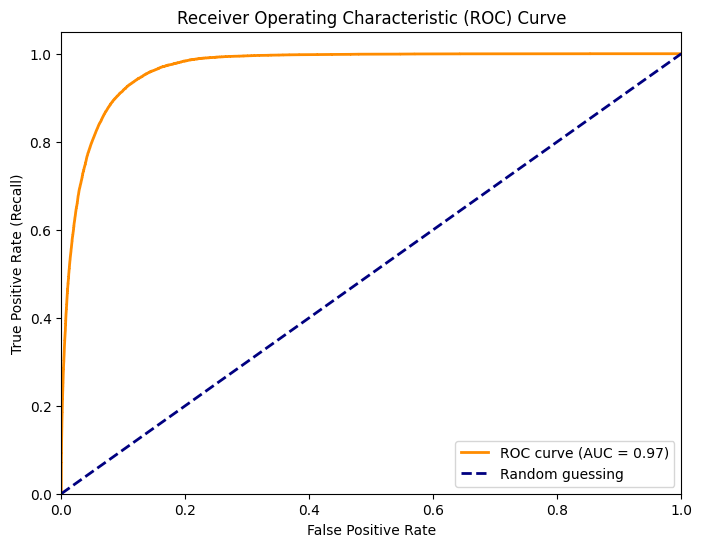

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [65]:
model_filename = 'banking_prediction.pkl'
joblib.dump(choosen_model, model_filename)

print(f"Model saved as {model_filename}")

Model saved as banking_prediction.pkl


In [69]:
model_metadata = {
    'optimal_threshold': float(result["threshold"]),
    'metrics_at_threshold': {
        'precision': float(precision_score(y_true, y_predict_change)),
        'recall': float(recall_score(y_true, y_predict_change)),
        'f1_score': float(f1_score(y_true, y_predict_change)),
    'dataset_info': 'banking prediction'
}
}


metadata_filename = 'model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=4)

print(f"Threshold and metadata saved as {metadata_filename}")

Threshold and metadata saved as model_metadata.json


# prepare competition file

In [74]:
#https://www.kaggle.com/datasets/kaggle/titanic
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load data
def load_data(path):
    return pd.read_csv(path)
    

competition = load_data('/kaggle/input/playground-series-s5e8/test.csv')


../input/playground-series-s5e8/sample_submission.csv
../input/playground-series-s5e8/train.csv
../input/playground-series-s5e8/test.csv


In [75]:
competition.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [82]:
y_scores = choosen_model.predict_proba(competition)[:, 1]

In [83]:
y_scores

array([1.6922784e-03, 7.6566793e-02, 2.4027446e-04, ..., 7.7600467e-01,
       4.8873870e-04, 1.2228480e-01], dtype=float32)

In [84]:
#https://www.kaggle.com/datasets/kaggle/titanic
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load data
def load_data(path):
    return pd.read_csv(path)
    

submit = load_data('/kaggle/input/playground-series-s5e8/sample_submission.csv')
submit.shape

../input/playground-series-s5e8/sample_submission.csv
../input/playground-series-s5e8/train.csv
../input/playground-series-s5e8/test.csv


(250000, 2)

In [85]:
submit.head()

,id,y
0,750000,0.5
1,750001,0.5
2,750002,0.5
3,750003,0.5
4,750004,0.5


In [86]:
submit["y"] = y_scores

In [88]:
submit.head()

,id,y
0,750000,0.001692
1,750001,0.076567
2,750002,0.000240
3,750003,0.000031
4,750004,0.022311


In [90]:
submit.to_csv("comptition.csv")